In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from datetime import timedelta

In [2]:
df = pd.read_pickle("../data/df.pickle")

In [3]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [4]:
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [5]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [6]:
"""Note
データセットの分割
lockdown(2020/4/1~2020/5/31)
2020/6/1~2020/10/31
2020/11/1~2020/11/30
2020/12/1~2020/12/31
2021/1/1~2021/12/31
2022/1/1~2022/12/31
2023/1/1~2023/9/30
"""

# データセットの分割
df_lockdown = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] <= "2020-05-31")]
df_202006_202010 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] <= "2020-10-31")]
df_202011 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] <= "2020-11-30")]
df_202012 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] <= "2020-12-31")]
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]

In [9]:
node_lockdown2, edge_lockdown2, timestamp_lockdown2 = getNetworkAnalysis(df_lockdown)
node_202006_2020102, edge_202006_2020102, timestamp_202006_2020102 = getNetworkAnalysis(df_202006_202010)
node_2020112, edge_2020112, timestamp_2020112 = getNetworkAnalysis(df_202011)
node_2020122, edge_2020122, timestamp_2020122 = getNetworkAnalysis(df_202012)
node_20212, edge_20212, timestamp_20212 = getNetworkAnalysis(df_2021)
node_20222, edge_20222, timestamp_20222 = getNetworkAnalysis(df_2022)
node_20232, edge_20232, timestamp_20232 = getNetworkAnalysis(df_2023)

In [14]:
alpha_list = []
beta_list = []
df_list = [df_lockdown, df_202006_202010, df_202011, df_202012, df_2021, df_2022, df_2023]
node_list = [node_lockdown2, node_202006_2020102, node_2020112, node_2020122, node_20212, node_20222, node_20232]
edge_list = [edge_lockdown2, edge_202006_2020102, edge_2020112, edge_2020122, edge_20212, edge_20222, edge_20232]
Np_list = [596, 673, 677, 677, 846, 1416,1416]

for i in range(len(df_list)):
    Np = Np_list[i]
    N = node_list[i]
    M = edge_list[i]
    df = df_list[i]
    # alphaとbetaの推定
    params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
    alpha_list.append(params[0])
    beta_list.append(params[1])

In [15]:
kappa_lockdown2 = []
for i in range(len(edge_lockdown2)):
    alpha = alpha_list[0]
    beta = beta_list[0]
    Np = Np_list[0]
    kappa_lockdown2.append(kappa(edge_lockdown2[i], Np))

kappa_202006_2020102 = []
for i in range(len(edge_202006_2020102)):
    alpha = alpha_list[1]
    beta = beta_list[1]
    Np = Np_list[1]
    kappa_202006_2020102.append(kappa(edge_202006_2020102[i], Np))

kappa_2020112 = []
for i in range(len(edge_2020112)):
    alpha = alpha_list[2]
    beta = beta_list[2]
    Np = Np_list[2]
    kappa_2020112.append(kappa(edge_2020112[i], Np))

kappa_2020122 = []
for i in range(len(edge_2020122)):
    alpha = alpha_list[3]
    beta = beta_list[3]
    Np = Np_list[3]
    kappa_2020122.append(kappa(edge_2020122[i], Np))

kappa_20212 = []
for i in range(len(edge_20212)):
    alpha = alpha_list[4]
    beta = beta_list[4]
    Np = Np_list[4]
    kappa_20212.append(kappa(edge_20212[i], Np))

kappa_20222 = []
for i in range(len(edge_20222)):
    alpha = alpha_list[5]
    beta = beta_list[5]
    Np = Np_list[5]
    kappa_20222.append(kappa(edge_20222[i], Np))

kappa_20232 = []
for i in range(len(edge_20232)):
    alpha = alpha_list[6]
    beta = beta_list[6]
    Np = Np_list[6]
    kappa_20232.append(kappa(edge_20232[i], Np))

In [33]:
# kappaのリストを結合する
kappa_list = kappa_lockdown2 + kappa_202006_2020102 + kappa_2020112 + kappa_2020122 + kappa_20212 + kappa_20222 + kappa_20232
node_list = node_lockdown2 + node_202006_2020102 + node_2020112 + node_2020122 + node_20212 + node_20222 + node_20232
edge_list = edge_lockdown2 + edge_202006_2020102 + edge_2020112 + edge_2020122 + edge_20212 + edge_20222 + edge_20232
print("length of kappa list:",len(kappa_list))
print("length of node list:",len(node_list))
print("length of edge list:",len(edge_list))

length of kappa list: 1269
length of node list: 1269
length of edge list: 1269


In [34]:
# kappa_list, node_list, edge_listをデータフレームに変換
df_kappa = pd.DataFrame({"kappa":kappa_list})
df_node = pd.DataFrame({"node":node_list})
df_edge = pd.DataFrame({"edge":edge_list})

In [ ]:
# それぞれのデータフレームを1つのデータフレームに結合
df = pd.concat([df_kappa, df_node, df_edge], axis=1)
df.to_pickle("../data/df_kappa.pickle")

In [26]:
# バイオリンプロット
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'

sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')

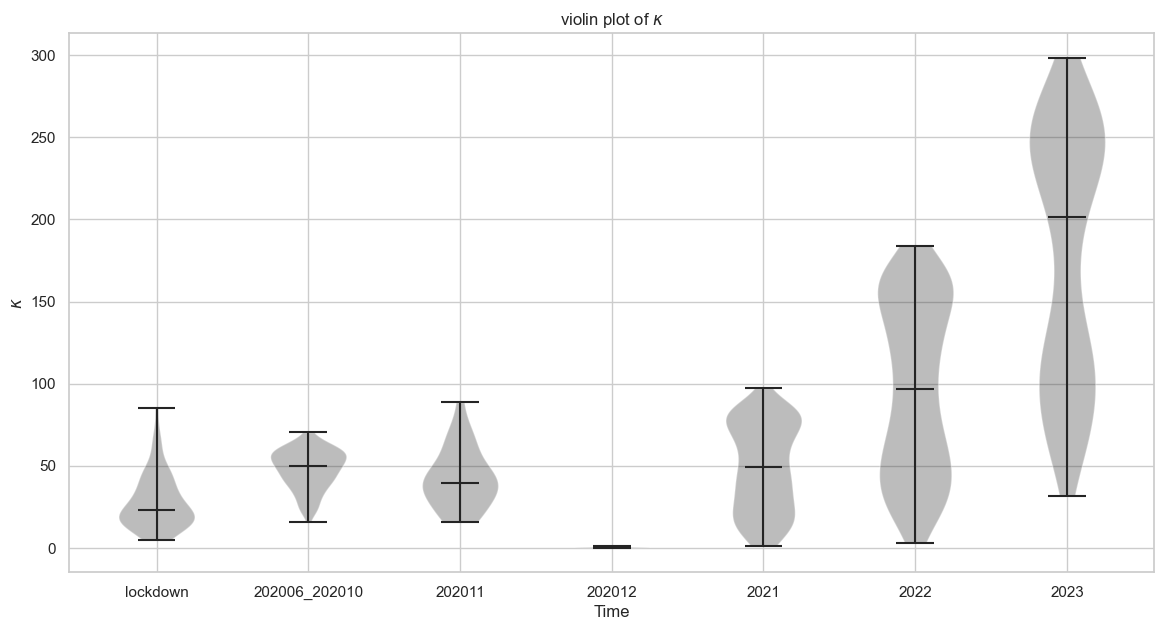

In [29]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)

ax.violinplot([kappa_lockdown2, kappa_202006_2020102, kappa_2020112, kappa_2020122, kappa_20212, kappa_20222, kappa_20232], showmedians=True)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['lockdown', '202006_202010', '202011', '202012', '2021', '2022', '2023'])
ax.set_xlabel('Time')
ax.set_ylabel(r'$\kappa$')
ax.set_title(r"violin plot of $\kappa$")
plt.savefig("../fig/violin_kappa.png")
plt.show()

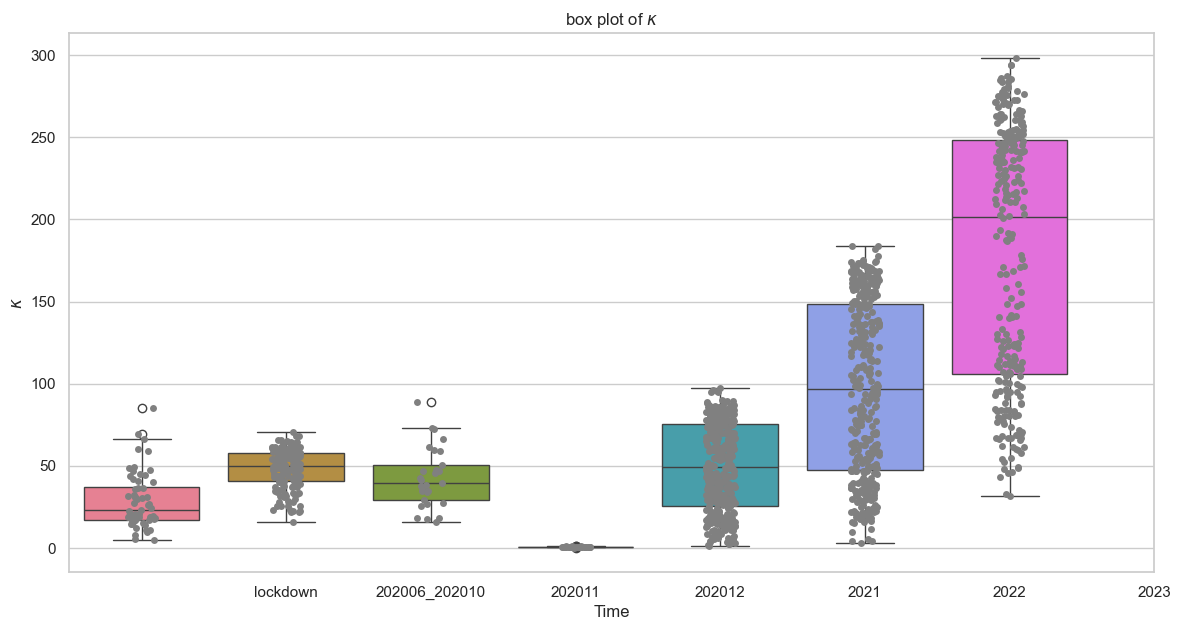

In [30]:
# ボックスプロット
plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)

sns.boxplot([kappa_lockdown2, kappa_202006_2020102, kappa_2020112, kappa_2020122, kappa_20212, kappa_20222, kappa_20232])
sns.stripplot([kappa_lockdown2, kappa_202006_2020102, kappa_2020112, kappa_2020122, kappa_20212, kappa_20222, kappa_20232], jitter=True, color="gray")
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['lockdown', '202006_202010', '202011', '202012', '2021', '2022', '2023'])
ax.set_xlabel('Time')
ax.set_ylabel(r'$\kappa$')
ax.set_title(r"box plot of $\kappa$")
plt.savefig("../fig/box_kappa.png")
plt.show()
